> Igor Sorochan DSU-31

# Data quality problems

In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px
import re



## Prepare

|data frame| used for storing:|
|:---|:---|
|df_raw | untouched input data|
|df | cleaned data|
|df_test|data for test w/o target labels|
|submission|exemplar for Kaggle submission|
| X | independent features|
|y (Series) | target labels|
|y_transformed (Series)|encoded target labels|
### EDA
#### Loading the data set

In [249]:
df_raw=pd.read_csv('/Users/velo1/SynologyDrive/GIT_syno/data/Titanic_train.csv')
df_test=pd.read_csv('/Users/velo1/SynologyDrive/GIT_syno/data/Titanic_test.csv')
# submission=pd.read_csv('/Users/velo1/SynologyDrive/GIT_syno/data/Titanic_gender_submission.csv')

In [250]:
df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [274]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [275]:
def check_na(df):
  for col in df.columns:
    print(f'{col.ljust(12)} {df[col].isna().sum():<5}{df[col].isna().sum()/df.shape[0]:.2%}')

In [276]:
check_na(df_raw)

PassengerId  0    0.00%
Survived     0    0.00%
Pclass       0    0.00%
Name         0    0.00%
Sex          0    0.00%
Age          177  19.87%
SibSp        0    0.00%
Parch        0    0.00%
Ticket       0    0.00%
Fare         0    0.00%
Cabin        687  77.10%
Embarked     2    0.22%


The data set is small, so we should try not to delete rows with nans but recover them.  
Age directly influnce on ones' chances to survive.  
Cabin may affects but it is not so obvious. 

### Age - passenger age  
We have 20% of nulls here.  
What attributes can indicate the age of a passenger?  
Potential candidates are:  
* Pclass  
* Name
Let's explore. 

In [277]:
df_raw.groupby(['Pclass'])[['Age']].mean().style.bar(align='mid', color='coral')

,Age
Pclass,
1,38.233441
2,29.877630
3,25.140620


There is strong correlation between Age and Pclass.  
The youngest passengers are in 3-rd Pclass.

Let's explore relations between Salutation and Age.  
The idea is to **roughly determine age on a passenger Salutation.**

First, we extract Salutations as any word from Name with a dot at the end. 

In [278]:
# df -dataframe for cleaned data
df = df_raw.copy()

pattern= re.compile(r'(\w+)\.')
df['Salutation']= df['Name'].apply(lambda x: re.findall(pattern, x)[0] )
df_test['Salutation']= df_test['Name'].apply(lambda x: re.findall(pattern, x)[0] ) # for test data
df.Salutation.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Salutation, dtype: int64

|Salutation|Description|Replacement|
|:---|:---|:---|
|Master|The term "Master" refers to young male passengers who were under the age of 18 and were traveling without their parents.  In the early 1900s, the term "Master" was commonly used as a courtesy title for boys, particularly those from wealthy or upper-class families.  The use of this title on passenger lists was a way to distinguish these young male passengers from adult male passengers.| Master|
|Rev|"Reverend", which is a title used to address members of the Christian clergy. | Mr|
|Mlle|French "Mademoiselle" (unmarried women)|Miss|
|Mme|French "Madame"|Mrs|
|Countess|The title of Countess is a noble title given to a woman in certain European countries.|Mrs|
|Jonkheer|The term "Jonkheer" is a Dutch noble title that is roughly equivalent to the English title of "Esquire".|Mr|
|Dona|Spanish  "Madam" or "Lady". There was only "Dona" onboard: Doña Fermina Oliva y Ocana. She was a 39-year-old first-class passenger from Spain who boarded the Titanic in Cherbourg, France, and disembarked in New York City. Doña Fermina Oliva y Ocana was traveling with her maid, Miss Asuncion Durán y More, who also survived the sinking. They both boarded lifeboat 8, which was one of the first to leave the Titanic. They were later transferred to the rescue ship Carpathia and eventually reached New York City on April 18, 1912.|Mrs|
|Major Col Capt Sir Don||Mr|


In [279]:
# extract salutation (any word followed by a dot) from name
salut = set(df_raw.Name.str.extract('(\w+)\.')[0])  # [0] to select the first column and convert to set to remove duplicates

# add the salutations from the test set
salut = salut | set(df_test.Name.str.extract('(\w+)\.')[0])  

salut

{'Capt',
 'Col',
 'Countess',
 'Don',
 'Dona',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'Ms',
 'Rev',
 'Sir'}

In [280]:
salut1

['Jonkheer',
 'Sir',
 'Mlle',
 'Dona',
 'Don',
 'Capt',
 'Ms',
 'Lady',
 'Major',
 'Rev',
 'Dr',
 'Col',
 'Mme',
 'Countess']

In [281]:
# remove proper salutation and convert to list as a set order in zip function is RANDOM
salut1 = list(salut - {'Master','Miss','Mr','Mrs'}) 

print('Set of replacements:')
# create a list of replacement for rare salutation
salut2 =['Mr', 'Mr','Miss', 'Mrs', 'Mr', 'Mr', 'Miss', 'Mrs', 'Mr', 'Mr',  'Mr', 'Mr', 'Mrs', 'Mrs']
for i in zip(salut1, salut2):
    print (i[0].ljust(9), i[1])

Set of replacements:
Jonkheer  Mr
Sir       Mr
Mlle      Miss
Dona      Mrs
Don       Mr
Capt      Mr
Ms        Miss
Lady      Mrs
Major     Mr
Rev       Mr
Dr        Mr
Col       Mr
Mme       Mrs
Countess  Mrs


In [282]:
df['Salutation'] = df.Salutation.replace(salut1, salut2)
df_test['Salutation'] = df_test.Salutation.replace(salut1, salut2)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Salutation
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Mr
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr


Look at Pass #887. We've managed to define him as a Mr.

In [283]:
# define a dictionary with the mean age for each salutation and class
df_age = pd.concat([df, df_test], axis= 0).groupby(['Salutation','Pclass'])[['Age']].mean().round(2)
age_dict = df_age.to_dict()['Age']
age_dict

{('Master', 1): 6.98,
 ('Master', 2): 2.76,
 ('Master', 3): 6.09,
 ('Miss', 1): 30.13,
 ('Miss', 2): 20.87,
 ('Miss', 3): 17.36,
 ('Mr', 1): 42.24,
 ('Mr', 2): 32.91,
 ('Mr', 3): 28.32,
 ('Mrs', 1): 42.8,
 ('Mrs', 2): 33.52,
 ('Mrs', 3): 32.33}

In [284]:
df_test[df_test.Salutation=='Ms' ] 

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Salutation


In [285]:
def add_age(row):
    '''
    Add age to missing values
    '''
    if np.isnan(row['Age']):
        return age_dict[row['Salutation'], row['Pclass']]
    else:
        return row['Age']

In [286]:
df.Age = df.apply(add_age, axis=1) # add the age to the dataframe
df_test.Age = df_test.apply(add_age, axis=1) # add the age to the TEST dataframe
df.loc[888,:] # check if the age was added           

PassengerId                                         889
Survived                                              0
Pclass                                                3
Name           Johnston, Miss. Catherine Helen "Carrie"
Sex                                              female
Age                                               17.36
SibSp                                                 1
Parch                                                 2
Ticket                                       W./C. 6607
Fare                                              23.45
Cabin                                               NaN
Embarked                                              S
Salutation                                         Miss
Name: 888, dtype: object

Here we see the result: Miss from 3 Pclass was given the age of 17.36.  
Unfortunately, she didn't survive the sinking.

In [287]:
check_na(df) # check if there are any missing values

PassengerId  0    0.00%
Survived     0    0.00%
Pclass       0    0.00%
Name         0    0.00%
Sex          0    0.00%
Age          0    0.00%
SibSp        0    0.00%
Parch        0    0.00%
Ticket       0    0.00%
Fare         0    0.00%
Cabin        687  77.10%
Embarked     2    0.22%
Salutation   0    0.00%


In [288]:
check_na(df_test) # check if there are missing values in the test set

PassengerId  0    0.00%
Pclass       0    0.00%
Name         0    0.00%
Sex          0    0.00%
Age          0    0.00%
SibSp        0    0.00%
Parch        0    0.00%
Ticket       0    0.00%
Fare         1    0.24%
Cabin        327  78.23%
Embarked     0    0.00%
Salutation   0    0.00%


Finally we've managed to fill missing ages and got the following Age distribution.

In [299]:
df.groupby(['Pclass','Sex'])[['Age']].mean().sort_values(by="Age", ascending= False).style.bar(align='mid', color='coral')

In [327]:
fig= px.histogram(df, x= 'Age', color= 'Survived', barmode='group', opacity=.7, height=600)
fig.update_layout(bargap=0.1, title_text='Age distribution', xaxis = dict(
        tickmode = 'linear', tick0 = 1, dtick = 2)
)

### Sibsp

"SibSp" is an abbreviation for "Sibling/Spouse".  
The values for "SibSp" range from 0  to 8 (indicating that the passenger had eight siblings or spouses on board).  


In [307]:
px.histogram(df, x=["SibSp", "Pclass"], color="Survived", barmode="group", opacity=.7)

In [291]:
df_raw.groupby(['Survived'])[['Age']].count().style.bar(align='mid', color='coral')

,Age
Survived,
0,424
1,290


In [292]:
train_data.groupby(['Sex', 'Survived'])[['Survived']].count().style.bar(align='mid', color='coral')

NameError: name 'train_data' is not defined

In [300]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Salutation'],
      dtype='object')

"Parch" is an abbreviation for "Parent/Child".  
The values for "Parch" range from 0 (indicating that the passenger had no parents or children on board) to 6 (indicating that the passenger had six parents or children on board).  

"Fare" refers to the amount of money paid by each passenger for their ticket. The values for "Fare" range from 0 (indicating that the passenger did not pay any fare, possibly due to a complimentary or staff ticket) to 512.3292 (the highest fare paid by any passenger on board). The fare could also indicate the passenger's socio-economic status or their cabin class on the ship.

"Embarked" refers to the port of embarkation of each passenger. The values for "Embarked" represent the following ports:

* C: Cherbourg
* Q: Queenstown (now known as Cobh)
* S: Southampton
These are the three ports from which the Titanic embarked on its maiden voyage. 

In [ ]:
# to simplify plots reading
category_names = {0: 'Not survived', 1: 'Survived'}
train_data['Survived '] = train_data['Survived'].map(category_names)

In [ ]:
# newnames ={0: 'Not', 1: 'Yes'}
fig=px.histogram(train_data, x='Survived ',  barmode='stack', color='Survived ', 
color_discrete_map={'Not survived':'firebrick', 'Survived':'lightgreen'},
 width=600, histfunc='count', text_auto=True) 
fig.update_layout( title='Passenger SURVIVAL. Target label distribution', xaxis_title="", yaxis_title="")
fig.update_xaxes(type='category') # format x_axes type
fig.update_layout(yaxis={
    # "tickvals": [],
    # "ticktext": [],
    "showticklabels": False
})
fig.update_layout(showlegend=False)

# fig.show()

There is a small target label imbalance.

In [ ]:
# fig=px.bar(train_data, x='Sex', y='Survived', barmode='group', color ='Survived', color_discrete_map={0:'red', 1:'green'},
#  width=600, title='Target label distribution',text_auto='')
# # fig.update_layout(title="Germany. COVID-19 Lockdown. ")#, xaxis_title="")
# fig.update_xaxes(type='category') # format x_axes type
# fig.show()

In [ ]:
# fig=px.histogram(train_data, x='Sex',  barmode='group', color ='Survived', color_discrete_map={0:'red', 1:'green'},
#  width=600, title='Target label distribution')
# # fig.update_layout(title="Germany. COVID-19 Lockdown. ")#, xaxis_title="")
# fig.update_xaxes(type='category') # format x_axes type
# fig.show()

In [ ]:
fig=px.histogram(train_data, x='Sex',  barmode='group', color='Survived ', 
color_discrete_map={'Not survived':'firebrick', 'Survived':'lightgreen'},width=600, histfunc='count', text_auto=True) 
fig.update_layout( title='Survival and passengers GENDER', xaxis_title="", yaxis_title="")
fig.update_xaxes(type='category') # format x_axes type
fig.update_layout(yaxis={
    # "tickvals": [],
    # "ticktext": [],
    "showticklabels": False
})

Female survival rate is much higher.

In [ ]:
fig=px.histogram(train_data, x=['Sex', 'Pclass'],  barmode='group', color='Survived ', 
color_discrete_map={'Not survived':'firebrick', 'Survived':'lightgreen'},width=600, histfunc='count', text_auto=True) 
fig.update_layout( title='Survival and passengers GENDER', xaxis_title="", yaxis_title="")
fig.update_xaxes(type='category') # format x_axes type
fig.update_layout(yaxis={
    # "tickvals": [],
    # "ticktext": [],
    "showticklabels": False
})

ValueError: Plotly Express cannot process wide-form data with columns of different type.

In [ ]:
# sb.countplot('Survived',data=train_data)
# plt.show()

From the above graph it is clear that not many persons survived. Out of 891 persons in training dataset only 350, 38.4% of total training dataset survived. We will get more insight of data by exploring more.

Here we'll explore features

In [ ]:
train_data.iloc[:,[1,2,4,0]].pivot_table( train_data.iloc[:,[1,2,4,0]], index= ['Sex', 'Survived','Pclass'], aggfunc=['count','mean'], margins= True)

count        mean
                       PassengerId PassengerId
Sex    Survived Pclass                        
female 0        1                3  325.000000
                2                6  423.500000
                3               72  440.375000
       1        1               91  473.967033
                2               70  444.785714
                3               72  359.083333
male   0        1               77  413.623377
                2               91  454.010989
                3              300  456.750000
       1        1               45  527.777778
                2               17  415.588235
                3               47  447.638298
All                            891  446.000000

In [ ]:
train_data.iloc[:,[1,2,4,0]].groupby(['Sex', 'Survived','Pclass']).agg({'PassengerId':('count','sum')}).style.bar(align='mid', color='coral')

It is clear that 233 female survived out of 344. And out of 577 male 109 survived. The survival ratio of female is much greater than that of male. It can be seen clearly in following graph

<AxesSubplot: xlabel='Sex'>

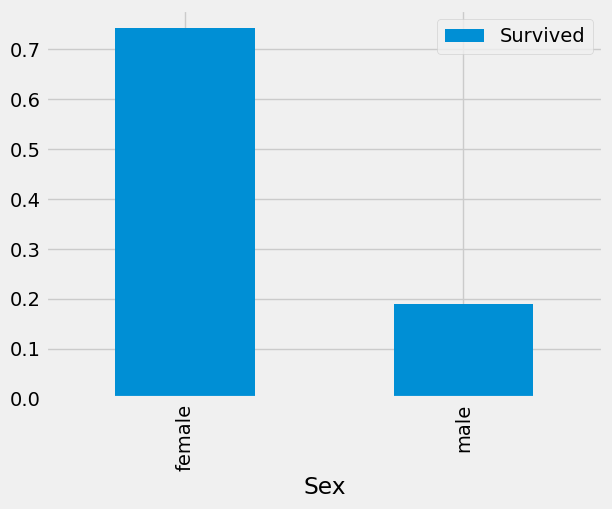

In [ ]:
train_data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar()


'Sex' is very interesting feature. Isn't it? Let's explore more features

In [ ]:
sb.countplot('Pclass', hue='Survived', data=train_data)
plt.title('Pclass: Sruvived vs Dead')
plt.show()

Wow.... That looks amazing. It is usually said that Money can't buy Everything, But it is clearly seen that pasangers of Class 1 are given high priority while Rescue. There are greater number of passangers in Class 3 than Class 1 and Class 2 but very few, almost 25% in Class 3 survived. In Class 2, survivail and non-survival rate is 49% and 51% approx. While in Class 1 almost 68% people survived. So money and status matters here.

Let's dive in again into data to check more interesting observations.

In [ ]:
pd.crosstab([train_data.Sex,train_data.Survived],train_data.Pclass,margins=True).style.background_gradient(cmap='summer_r')

In [ ]:
sb.factorplot('Pclass', 'Survived', hue='Sex', data=train_data)
plt.show()

I use FactorPlot and CrossTab here because with these plots categorical variables can easily be visualized. Looking at FactorPlot and CrossTab, it is clear that women survival rate in Class 1 is about 95-96%, as only 3 out of 94 women died. So, it is now more clear that irrespective of Class, women are given first priority during Rescue. Because survival rate for men in even Class 1 is also very low. From this conclusion, PClass is also a important feature.

In [ ]:
print('Oldest person Survived was of:',train_data['Age'].max())
print('Youngest person Survived was of:',train_data['Age'].min())
print('Average person Survived was of:',train_data['Age'].mean())

In [ ]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sb.violinplot('Pclass','Age',hue='Survived',data=train_data,split=True,ax=ax[0])
ax[0].set_title('PClass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sb.violinplot("Sex","Age", hue="Survived", data=train_data,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

From above violen plots, following observations are clear,

1) The no of children is increasing from Class 1 to 3, the number of children in Class 3 is greater than other two. 2) Survival rate of children, for age 10 and below is good irrespective of Class 3) Survival rate between age 20-30 is well and is quite better for women.

Now, in Age feature we have 177 null values filled with NaN. We have to deal with it. But we can't enter mean of age in every NaN column, because our average/mean is 29 and we cannot put 29 for a child or some olde man. So we have to discover something better. Let's do something more interesting with dataset by exploring more.

add Codeadd Markdown
What is, if I look at 'Name' feature, It looks interesting. Let's check it....

In [ ]:
train_data['Initial']=0
for i in train_data:
    train_data['Initial']=train_data.Name.str.extract('([A-Za-z]+)\.') #extracting Name initials

In [ ]:
pd.crosstab(train_data.Initial,train_data.Sex).T.style.background_gradient(cmap='summer_r')

There are many names which are not relevant like Mr, Mrs etc. So I will replace them with some relevant names,

In [ ]:
train_data.groupby('Initial')['Age'].mean()


From the above plots, I found the following observations

(1) First priority during Rescue is given to children and women, as the persons<5 are save by large numbers  
(2) The oldest saved passanger is of 80  
(3) The most deaths were between 30-40

In [ ]:
sb.factorplot('Pclass','Survived',col='Initial',data=train_data)
plt.show()



From the above FactorPlots it is Clearly seen that women and children were saved irrespective of PClass


Let's explore some more

Feature: SibSip

SibSip feature indicates that whether a person is alone or with his family. Siblings=brother,sister, etc and Spouse= husband,wife

In [ ]:
pd.crosstab([train_data.SibSp],train_data.Survived).style.background_gradient('summer_r')

In [ ]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sb.barplot('SibSp','Survived', data=train_data,ax=ax[0])
ax[0].set_title('SipSp vs Survived in BarPlot')
sb.factorplot('SibSp','Survived', data=train_data,ax=ax[1])
ax[1].set_title('SibSp vs Survived in FactorPlot')
plt.close(2)
plt.show()

In [ ]:
pd.crosstab(train_data.SibSp,train_data.Pclass).style.background_gradient('summer_r')

There are many interesting facts with this feature. Barplot and FactorPlot shows that if a passanger is alone in ship with no siblings, survival rate is 34.5%. The graph decreases as no of siblings increase. This is interesting because, If I have a family onboard, I will save them instead of saving myself. But there's something wrong, the survival rate for families with 5-8 members is 0%. Is this because of PClass? Yes this is PClass, The crosstab shows that Person with SibSp>3 were all in Pclass3. It is imminent that all the large families in Pclass3(>3) died.

That are some interesting facts we have observed with Titanic dataset.